In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install bert

In [ ]:
# !pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModel, BertTokenizerFast
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [ ]:
from transformers import AutoTokenizer, BertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df = pd.read_csv ('/content/drive/MyDrive/ADRXAI/FinalADR.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df=df.dropna()
df.head()

,text,searchTerm,disease,processed_text
0,Buy top levothyroxine online on our free compa...,Levothyroxine,Cancer,"['buy', 'top', 'free', 'comparison', 'site', '..."
1,@femmebostonian @Cherrell_Brown This has been ...,Levothyroxine,Cancer,"['super', 'help', 'switch', 'due', 'cost', 'ne..."
2,For a decade I was on Levothyroxine 137 mcg. I...,Levothyroxine,Cancer,"['decad', 'see', 'even', 'bit', 'bad', 'heart'..."
3,@yourAAH Hi could you tell me which of your UK...,Levothyroxine,Cancer,"['hi', 'could', 'tell', 'stock']"
4,And my levothyroxine,Levothyroxine,Cancer,[]


	ext Length Statistics:

count    3937.000000
mean      162.441707
std        56.888090
min         5.000000
25%       141.000000
50%       156.000000
75%       173.000000
max       649.000000
Name: text, dtype: float64


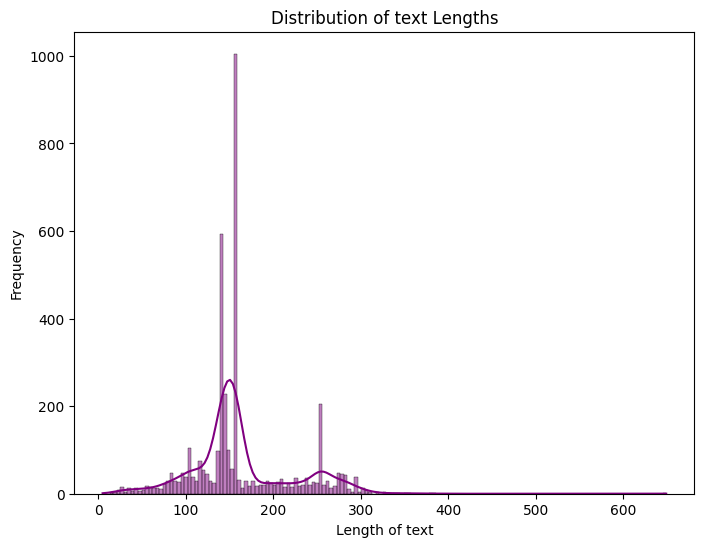

In [ ]:
annotations_lengths = df['text'].apply(len)
print("\text Length Statistics:\n")
print(annotations_lengths.describe())

plt.figure(figsize=(8, 6))
sns.histplot(annotations_lengths, kde=True, color='purple')
plt.title('Distribution of text Lengths')
plt.xlabel('Length of text')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df['char_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['token_count'] = df['text'].apply(lambda x: len(tokenizer.tokenize(x)))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3937 entries, 0 to 3944
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            3937 non-null   object
 1   searchTerm      3937 non-null   object
 2   disease         3937 non-null   object
 3   processed_text  3937 non-null   object
 4   char_length     3937 non-null   int64 
 5   word_count      3937 non-null   int64 
 6   token_count     3937 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 246.1+ KB


In [ ]:
df.head()

,text,searchTerm,disease,processed_text,char_length,word_count,token_count
0,Buy top levothyroxine online on our free compa...,Levothyroxine,Cancer,"['buy', 'top', 'free', 'comparison', 'site', '...",135,19,53
1,@femmebostonian @Cherrell_Brown This has been ...,Levothyroxine,Cancer,"['super', 'help', 'switch', 'due', 'cost', 'ne...",248,41,66
2,For a decade I was on Levothyroxine 137 mcg. I...,Levothyroxine,Cancer,"['decad', 'see', 'even', 'bit', 'bad', 'heart'...",252,49,71
3,@yourAAH Hi could you tell me which of your UK...,Levothyroxine,Cancer,"['hi', 'could', 'tell', 'stock']",88,15,29
4,And my levothyroxine,Levothyroxine,Cancer,[],20,3,8


In [ ]:
disease_counts = df['disease'].value_counts()

disease_counts

,count
disease,
Diabetes,1805
Cancer,1212
High_Bp,920


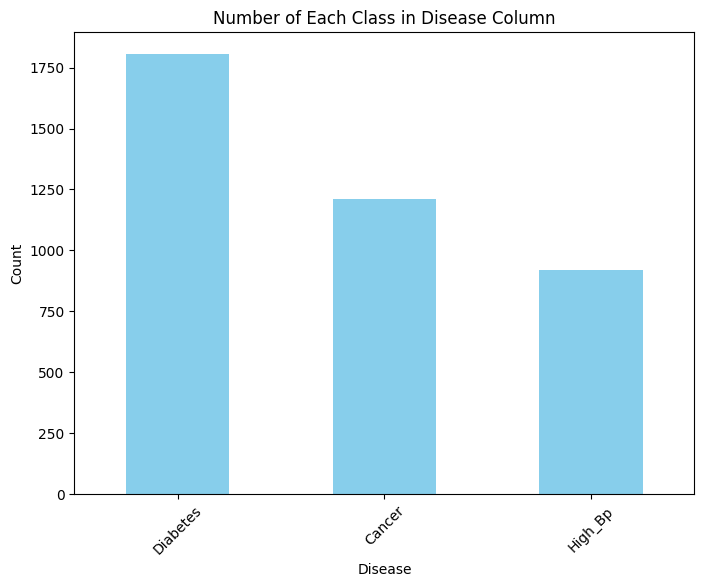

In [ ]:
import matplotlib.pyplot as plt

# Generate barplot for the disease counts
plt.figure(figsize=(8, 6))
disease_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Each Class in Disease Column')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
import nltk
import re
import string
import pandas as pd
import numpy as np
from wordcloud import WordCloud
string.punctuation

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt_tab')
# Initialize stop words, English words corpus, and stemmer
stop_words = set(stopwords.words('english'))
english_words = set(words.words())
# stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the text column
df['Cleantext'] = df['text'].apply(preprocess)

In [ ]:
df.head()

,text,searchTerm,disease,processed_text,char_length,word_count,token_count,Cleantext
0,Buy top levothyroxine online on our free compa...,Levothyroxine,Cancer,"['buy', 'top', 'free', 'comparison', 'site', '...",135,19,53,buy top levothyroxine online free comparison s...
1,@femmebostonian @Cherrell_Brown This has been ...,Levothyroxine,Cancer,"['super', 'help', 'switch', 'due', 'cost', 'ne...",248,41,66,femmebostonian cherrellbrown super helpful swi...
2,For a decade I was on Levothyroxine 137 mcg. I...,Levothyroxine,Cancer,"['decad', 'see', 'even', 'bit', 'bad', 'heart'...",252,49,71,decade levothyroxine mcg seeing changes sympto...
3,@yourAAH Hi could you tell me which of your UK...,Levothyroxine,Cancer,"['hi', 'could', 'tell', 'stock']",88,15,29,youraah hi could tell uk pharmacies stock mcg ...
4,And my levothyroxine,Levothyroxine,Cancer,[],20,3,8,levothyroxine


In [ ]:
df['text'][0]

'Buy top levothyroxine online on our free comparison site! BEST OFFER SUPER PRICES -Best Place To Compare Prices https://t.co/wAoqUl71is'

In [ ]:
df['Cleantext'][0]

'buy top levothyroxine online free comparison site best offer super prices best place compare prices httpstcowaoqulis'

In [ ]:
X=df.Cleantext
Y=df.disease
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.33, random_state=42)

# Further split temp into test and validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
print(f'(X_train: {len(X_train)}\nx_val: {len(X_val)}\nx_test: {len(X_test)})')

(X_train: 2637
x_val: 650
x_test: 650)


In [ ]:
y_test[:1]

,disease
393,Cancer


In [ ]:
X_test[:1]

,Cleantext
393,regulatory news us food drug administration dr...


### Create a dataset for shap

In [ ]:
!pip install datasets

In [ ]:
from datasets import Dataset

# Assuming X_test and y_test are pandas DataFrames or lists
data_dict = {
    'text': X_test.tolist(),  # Cleaned text (X_test)
    'label': y_test.tolist()  # Disease labels (y_test)
}

# Create a Hugging Face dataset
test_data = Dataset.from_dict(data_dict)

# Now test_dataset is a Hugging Face dataset


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

# Optionally, add the encoded labels back to your DataFrames
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)


In [ ]:
X_train = X_train.tolist()
y_train = y_train.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()
y_val=y_val.tolist()
X_val=X_val.tolist()


In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=649)
valid_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=649)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=649)


In [ ]:
class DATALOADER(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = DATALOADER(train_encodings, y_train)
valid_dataset = DATALOADER(valid_encodings, y_val)
test_dataset = DATALOADER(test_encodings, y_test)

In [ ]:
from transformers import AutoModelForSequenceClassification,AutoConfig

id2label = {0: 'Cancer', 1: 'High_Bp', 2: 'Diabetes'}
label2id = {label: idx for idx, label in id2label.items()}

# Load and update the configuration
config = AutoConfig.from_pretrained("bert-base-cased")
config.id2label = id2label
config.label2id = label2id
config.num_labels = len(id2label)  # Set the number of labels in the config

# Load the model using the updated config
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./bert',
    num_train_epochs=10,
    fp16=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    logging_steps=200,
    save_steps=200,
    evaluation_strategy="steps",
    learning_rate=3e-5, # A common choice for fine-tuning BERT
    report_to=None  # Disables all integrations, including wandb
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import  Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
import os
os.environ["WANDB_SILENT"] = "true"
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_API_KEY"] = ""  # Clear any stored API key


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Accuracy
200,1.005700,0.082286,0.975385
400,0.120500,0.119490,0.976923
600,0.126600,0.104598,0.981538
800,0.080000,0.089713,0.983077
1000,0.062300,0.083200,0.978462
1200,0.048800,0.066884,0.981538
1400,0.030400,0.076432,0.978462
1600,0.026600,0.076180,0.981538


TrainOutput(global_step=1650, training_loss=0.183519606590271, metrics={'train_runtime': 484.5002, 'train_samples_per_second': 54.427, 'train_steps_per_second': 3.406, 'total_flos': 1355136879978000.0, 'train_loss': 0.183519606590271, 'epoch': 10.0})

# History plot

In [ ]:
history = trainer.state.log_history


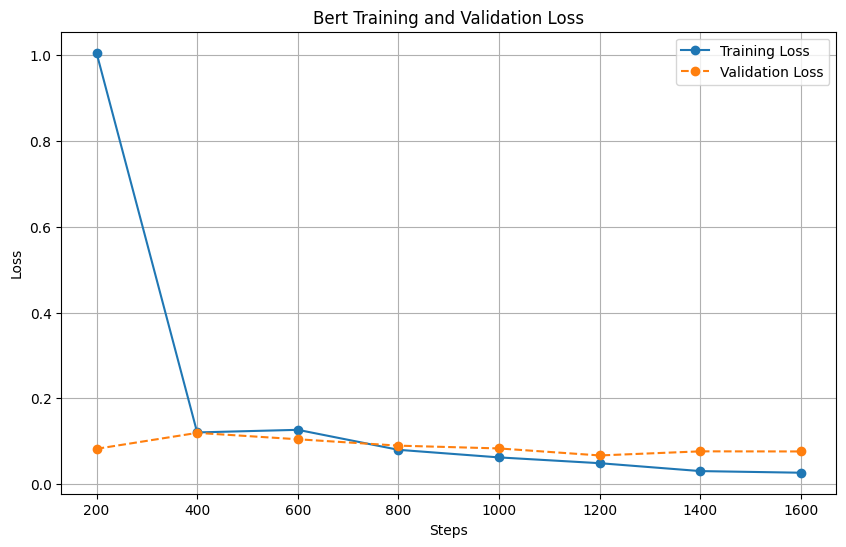

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation losses
train_loss = [entry['loss'] for entry in history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry]
steps = [entry['step'] for entry in history if 'step' in entry and 'loss' in entry]

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label='Training Loss', marker='o')
plt.plot(steps, eval_loss, label='Validation Loss', marker='o', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Bert Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


# ROC Plot

In [ ]:
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
true_labels = predictions.label_ids


In [ ]:
import torch
import torch.nn.functional as F

# Convert logits to probabilities
probabilities = F.softmax(torch.tensor(logits), dim=-2).numpy()


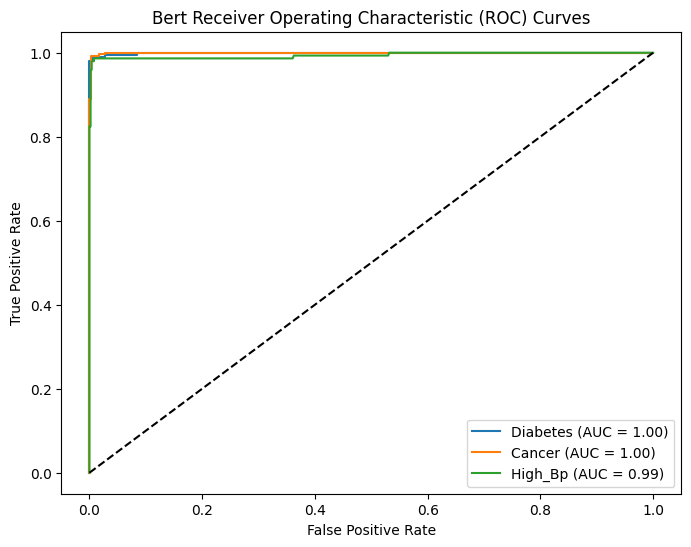

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming these are your class names
class_names = ['Diabetes', 'Cancer', 'High_Bp']  # Replace with your actual class names

num_classes = 3
true_labels_binarized = label_binarize(true_labels, classes=list(range(num_classes)))

# Compute ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bert Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()


In [ ]:
for i in range(num_classes):
    print(f'Class {i} AUC: {roc_auc[i]:.2f}')


Class 0 AUC: 1.00
Class 1 AUC: 1.00
Class 2 AUC: 0.99


## Saved model

In [ ]:
# saving the fine tuned model & tokenizer
model_path = "/content/drive/MyDrive/ADRXAI/Finalbert"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/ADRXAI/Finalbert/tokenizer_config.json',
 '/content/drive/MyDrive/ADRXAI/Finalbert/special_tokens_map.json',
 '/content/drive/MyDrive/ADRXAI/Finalbert/vocab.txt',
 '/content/drive/MyDrive/ADRXAI/Finalbert/added_tokens.json',
 '/content/drive/MyDrive/ADRXAI/Finalbert/tokenizer.json')

## Evaluated model

In [ ]:
eval_results =trainer.evaluate(test_dataset)

# Predict on the evaluation dataset to get logits
predictions = trainer.predict(test_dataset)

In [ ]:
eval_results

{'eval_loss': 0.08118918538093567,
 'eval_accuracy': 0.9830769230769231,
 'eval_runtime': 2.8405,
 'eval_samples_per_second': 228.834,
 'eval_steps_per_second': 28.868,
 'epoch': 10.0}

In [ ]:
import numpy as np

# Extract true labels
true_labels = predictions.label_ids

# Extract predicted labels (argmax over logits)
preds = np.argmax(predictions.predictions, axis=1)


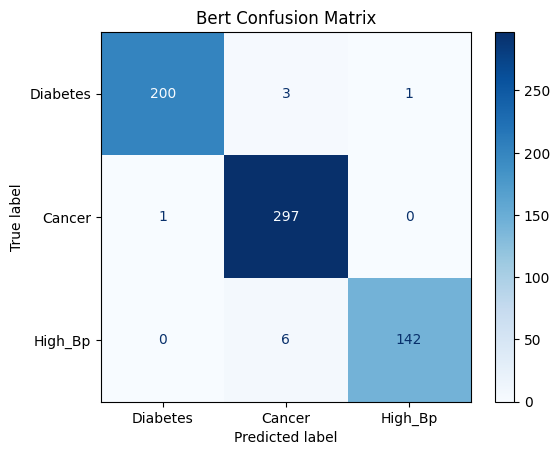

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = ['Diabetes', 'Cancer', 'High_Bp']

# Compute the confusion matrix
cm = confusion_matrix(true_labels, preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.title('Bert Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Assuming true_labels and preds are already defined
print(classification_report(true_labels, preds, target_names=labels))


              precision    recall  f1-score   support

    Diabetes       1.00      0.98      0.99       204
      Cancer       0.97      1.00      0.98       298
     High_Bp       0.99      0.96      0.98       148

    accuracy                           0.98       650
   macro avg       0.99      0.98      0.98       650
weighted avg       0.98      0.98      0.98       650



In [ ]:
import shap
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Define the path to your fine-tuned model and tokenizer
model_path = '/content/drive/MyDrive/ADRXAI/Finalbert'

# Load the fine-tuned model and tokenizer from the saved path
tokenizer = AutoTokenizer.from_pretrained(model_path)
model1 = AutoModelForSequenceClassification.from_pretrained(model_path)

pred = transformers.pipeline(
    "text-classification",
    model=model1,
    tokenizer=tokenizer,
    device=0,
    return_all_scores=True,
)

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
test_data

Dataset({
    features: ['text', 'label'],
    num_rows: 650
})

In [ ]:
data = pd.DataFrame({"text": test_data["text"], "disease": test_data["label"]})

In [ ]:
data[:3]

,text,disease
0,regulatory news us food drug administration dr...,Cancer
1,carvedilol district court case may needed prov...,High_Bp
2,rt pharmafactz antidiabetics rapidacting lispr...,Diabetes


In [ ]:
data['text'][0]

'regulatory news us food drug administration drug updates approvals changes wednesday april fda amlodipine besylate anda flagyl er nda rituxan bla others httpstcoopxuvelz'

In [ ]:
explainer = shap.Explainer(pred)

In [ ]:
shap_values = explainer(data["text"][:3])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 3/3 [00:31<00:00,  6.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [00:40, 13.63s/it]


In [ ]:
shap.plots.text(shap_values)